# hugging face custom dataset import

In [1]:
from datasets import load_dataset
data = load_dataset("../data/6-parameter-maps/6-parameter-maps.py", cache_dir="/pscratch/sd/s/shubh/")

Found cached dataset 6-parameter-maps (/pscratch/sd/s/shubh/6-parameter-maps/first_domain/1.1.0/44f53b896c5a63d6ef78326ce78ac966d5a5b8975036485ccd2fc5423db2f32d)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
# id2label = {id:label for id, label in enumerate(data["train"].features) if label != "map"}
id2label = {id:label for id, label in enumerate(["Omega_m", "sigma_8"])}
label2id = {label:id for id,label in id2label.items()}
id2label, label2id

({0: 'Omega_m', 1: 'sigma_8'}, {'Omega_m': 0, 'sigma_8': 1})

# ResNet

In [6]:
from transformers import AutoImageProcessor, ResNetForImageClassification, ResNetConfig, ResNetModel

checkpoint = "microsoft/resnet-50"
model = ResNetForImageClassification.from_pretrained(checkpoint, # num_labels=2, \
            problem_type = "regression", id2label=id2label, label2id=label2id,
            num_channels=1, ignore_mismatched_sizes=True)

print(model.config.problem_type)
print(model.config.num_labels)

model

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- resnet.embedder.embedder.convolution.weight: found shape torch.Size([64, 3, 7, 7]) in the checkpoint and torch.Size([64, 1, 7, 7]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


regression
2


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [10]:
model.config

ResNetConfig {
  "_name_or_path": "microsoft/resnet-50",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    4,
    6,
    3
  ],
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "Omega_m",
    "1": "sigma_8"
  },
  "label2id": {
    "Omega_m": 0,
    "sigma_8": 1
  },
  "layer_type": "bottleneck",
  "model_type": "resnet",
  "num_channels": 1,
  "out_features": [
    "stage4"
  ],
  "out_indices": [
    4
  ],
  "problem_type": "regression",
  "stage_names": [
    "stem",
    "stage1",
    "stage2",
    "stage3",
    "stage4"
  ],
  "torch_dtype": "float32",
  "transformers_version": "4.28.1"
}

In [11]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
import numpy as np 
from matplotlib import pyplot as plt
from PIL import Image

size = (224, 224)

print(size)

# train_data_augmentation = keras.Sequential(
#     [
#         layers.Resizing(size[0], size[1]),
#         layers.Normalization(),
#         layers.RandomFlip("horizontal"),
#         layers.RandomFlip("vertical"),
#     ],
#     name="train_data_augmentation",
# )

# val_data_augmentation = keras.Sequential(
#     [
#         layers.Resizing(size[0], size[1]),
#         layers.Normalization(),
#     ],
#     name="val_data_augmentation",
# )

from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomVerticalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=0, std=1)

train_data_augmentation = Compose(
        [
            Resize(size),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_data_augmentation = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )

(224, 224)


In [12]:
# def convert_to_tf_tensor(image: Image):
#     return tf.expand_dims(tf.convert_to_tensor(np.asarray(image)), axis=-1)


# def preprocess_train(example_batch):
#     """Apply train_transforms across a batch."""
#     images = [
#         train_data_augmentation(convert_to_tf_tensor(image)) for image in example_batch["map"]
#     ]
#     example_batch["labels"] = tf.transpose([example_batch[x] for x in example_batch.keys() if x != "map"])
#     example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
#     return example_batch


# def preprocess_val(example_batch):
#     """Apply val_transforms across a batch."""
#     images = [
#         val_data_augmentation(convert_to_tf_tensor(image)) for image in example_batch["map"]
#     ]
#     example_batch["labels"] = tf.transpose([example_batch[x] for x in example_batch.keys() if x != "map"])
#     example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
#     return example_batch

def preprocess_train(examples):
    # examples["labels"] = np.transpose([examples[x] for x in examples.keys() if x != "map"]).astype(np.float32)
    examples["labels"] = np.transpose([examples[x] for x in ["Omega_m", "sigma_8"]]).astype(np.float32)
    examples['pixel_values'] = [train_data_augmentation(image) for image in examples['map']]
    return examples

def preprocess_val(examples):
    # examples["labels"] = np.transpose([examples[x] for x in examples.keys() if x != "map"]).astype(np.float32)
    examples["labels"] = np.transpose([examples[x] for x in ["Omega_m", "sigma_8"]]).astype(np.float32)
    examples['pixel_values'] = [val_data_augmentation(image) for image in examples['map']]
    return examples

data["train"].set_transform(preprocess_train)
data["validation"].set_transform(preprocess_val)
data["test"].set_transform(preprocess_val)

In [13]:
data["train"][0:3]

{'Omega_m': [0.10410156100988388, 0.39335936307907104, 0.20000000298023224],
 'H_0': [79.9873046875, 79.732421875, 77.5],
 'n_s': [0.9730273485183716, 1.0655077695846558, 0.9200000166893005],
 'sigma_8': [0.9395507574081421, 0.7017577886581421, 1.149999976158142],
 'w_0': [-0.36800047755241394, -0.520211935043335, -0.749750018119812],
 'map': [<PIL.TiffImagePlugin.TiffImageFile image mode=F size=66x66>,
  <PIL.TiffImagePlugin.TiffImageFile image mode=F size=66x66>,
  <PIL.TiffImagePlugin.TiffImageFile image mode=F size=66x66>],
 'labels': array([[0.10410156, 0.93955076],
        [0.39335936, 0.7017578 ],
        [0.2       , 1.15      ]], dtype=float32),
 'pixel_values': [tensor([[[-0.0025, -0.0025, -0.0025,  ..., -0.0051, -0.0052, -0.0052],
           [-0.0025, -0.0025, -0.0025,  ..., -0.0051, -0.0052, -0.0052],
           [-0.0022, -0.0022, -0.0021,  ..., -0.0049, -0.0049, -0.0049],
           ...,
           [ 0.0004,  0.0004, -0.0003,  ..., -0.0049, -0.0049, -0.0049],
           [ 

In [14]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(data["train"], collate_fn=collate_fn, batch_size=4)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 1, 224, 224])
labels torch.Size([4, 2])


/tmp/ipykernel_255382/3338418760.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  labels = torch.tensor([example["labels"] for example in examples])


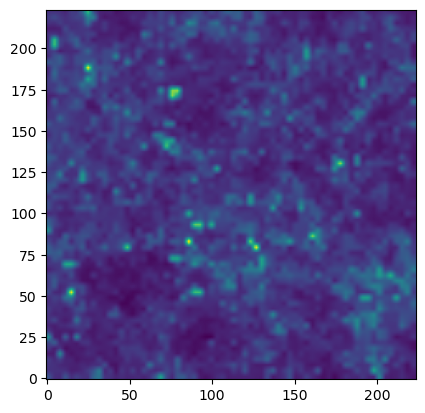

In [16]:
plt.imshow(data["train"][0]["pixel_values"][0], origin="lower")
plt.show()
plt.close()

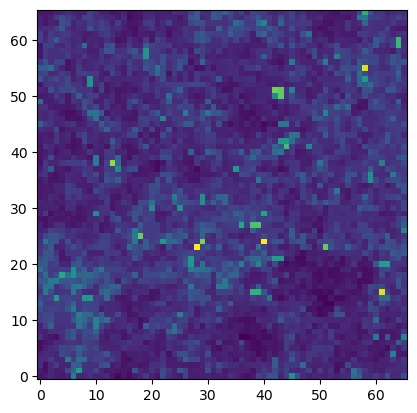

In [17]:
plt.imshow(np.asarray(data["train"][0]["map"]), origin="lower")
plt.show()
plt.close()

In [18]:
from transformers import create_optimizer

batch_size = 32
num_epochs = 5
num_train_steps = len(data["train"]) * num_epochs
learning_rate = 0.001
weight_decay_rate = 0.0001

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

2023-05-10 08:57:04.555053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 08:57:06.553452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [19]:
# from transformers import DefaultDataCollator
# data_collator = DefaultDataCollator(return_tensors="tf")

# # converting our train dataset to tf.data.Dataset
# tf_train_dataset = data["train"].to_tf_dataset(
#     columns=["pixel_values", "Omega_m", "H_0", "n_s", "sigma_8", "w_0"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
# )

# # converting our test dataset to tf.data.Dataset
# tf_eval_dataset = data["test"].to_tf_dataset(
#     columns=["pixel_values", "Omega_m", "H_0", "n_s", "sigma_8", "w_0"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
# )

In [20]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"test",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    num_train_epochs=5,
    weight_decay=0.0001,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [21]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset= data["train"],
    eval_dataset= data["validation"],
    data_collator=collate_fn
)

In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.004600,0.004737
2,0.004200,0.003879
3,0.004200,0.003755
4,0.004300,0.003760
5,0.004400,0.003768


TrainOutput(global_step=50000, training_loss=0.0043885297298431394, metrics={'train_runtime': 2829.9395, 'train_samples_per_second': 141.346, 'train_steps_per_second': 17.668, 'total_flos': 2.8306318344192e+18, 'train_loss': 0.0043885297298431394, 'epoch': 5.0})

In [30]:
from pathlib import Path

# out_dir = "../models/20230905_vit/"
out_dir = "../models/20230906_resnet_2var_more/"
Path(out_dir).mkdir(parents=True, exist_ok=True)

trainer.save_model(out_dir)

In [31]:
preds = trainer.predict(data["validation"])
preds

PredictionOutput(predictions=array([[0.28957385, 0.47728515],
       [0.24073224, 1.0994279 ],
       [0.43369734, 0.7411469 ],
       ...,
       [0.22832927, 1.0946568 ],
       [0.23843063, 0.67839605],
       [0.42549628, 0.5934422 ]], dtype=float32), label_ids=array([[0.29335937, 0.45175782],
       [0.22929688, 1.252539  ],
       [0.4260742 , 0.7781738 ],
       ...,
       [0.253125  , 1.1890625 ],
       [0.1595703 , 0.8008789 ],
       [0.47148436, 0.5064453 ]], dtype=float32), metrics={'test_loss': 0.0037554928567260504, 'test_runtime': 17.9618, 'test_samples_per_second': 556.737, 'test_steps_per_second': 69.592})

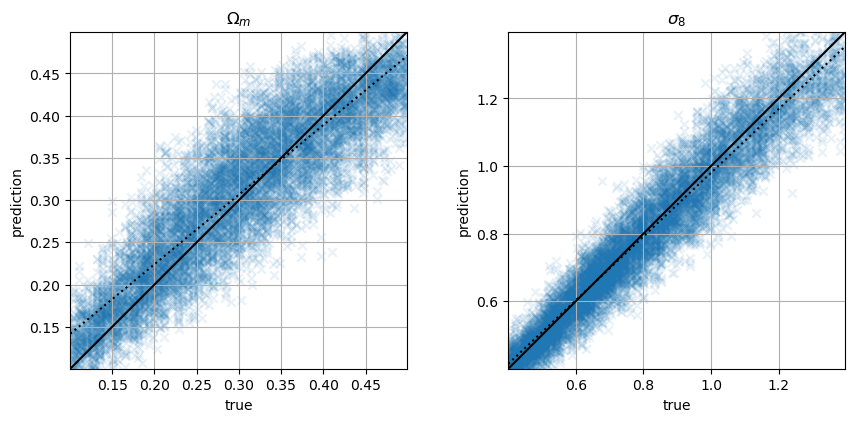

In [34]:
plot_y, predictions = preds.label_ids, preds.predictions

upp_lims = np.nanmax(plot_y, axis=0)
low_lims = np.nanmin(plot_y, axis=0)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = [r"$\Omega_m$", r"$\sigma_8$"]
for ind, (label, ax, low_lim, upp_lim) in enumerate(zip(labels, axs.ravel(), low_lims, upp_lims)):
    p = np.poly1d(np.polyfit(plot_y[:, ind], predictions[:, ind], 1))
    ax.scatter(plot_y[:, ind], predictions[:, ind], marker="x", alpha=0.1)
    ax.set_xlabel("true")
    ax.set_ylabel("prediction")
    ax.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
    ax.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
    ax.set_xlim([low_lim, upp_lim])
    ax.set_ylim([low_lim, upp_lim])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(label)
    ax.grid()
plt.show()
plt.close()

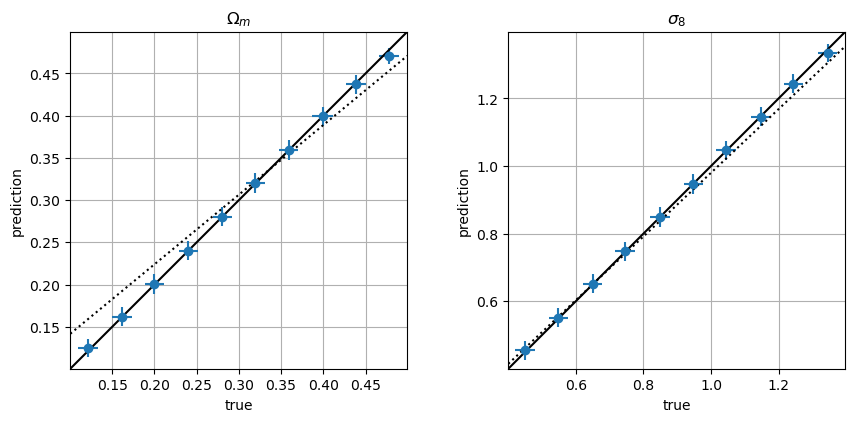

In [45]:
def bin_values_with_errors(data, num_bins, bin_range):
    counts, bin_edges = np.histogram(data, bins=num_bins, range=bin_range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    bin_means = np.zeros(num_bins)
    bin_stddevs = np.zeros(num_bins)
    for i in range(num_bins):
        bin_indices = np.where((data >= bin_edges[i]) & (data < bin_edges[i + 1]))
        bin_values = data[bin_indices]
        bin_means[i] = np.mean(bin_values)
        bin_stddevs[i] = np.std(bin_values)

    return bin_centers, bin_means, bin_stddevs

num_bins = 10

upp_lims = np.nanmax(plot_y, axis=0)
low_lims = np.nanmin(plot_y, axis=0)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = [r"$\Omega_m$", r"$\sigma_8$"]
for ind, (label, ax, low_lim, upp_lim) in enumerate(zip(labels, axs.ravel(), low_lims, upp_lims)):
    pbin_centers, pbin_means, pbin_stddevs = bin_values_with_errors(predictions[:, ind], num_bins, (low_lim, upp_lim))
    ybin_centers, ybin_means, ybin_stddevs = bin_values_with_errors(plot_y[:, ind], num_bins, (low_lim, upp_lim))
    p = np.poly1d(np.polyfit(plot_y[:, ind], predictions[:, ind], 1))
    ax.errorbar(ybin_means, pbin_means, yerr=pbin_stddevs, xerr=ybin_stddevs, fmt="o")
    ax.set_xlabel("true")
    ax.set_ylabel("prediction")
    ax.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
    ax.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
    ax.set_xlim([low_lim, upp_lim])
    ax.set_ylim([low_lim, upp_lim])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(label)
    ax.grid()
plt.show()
plt.close()

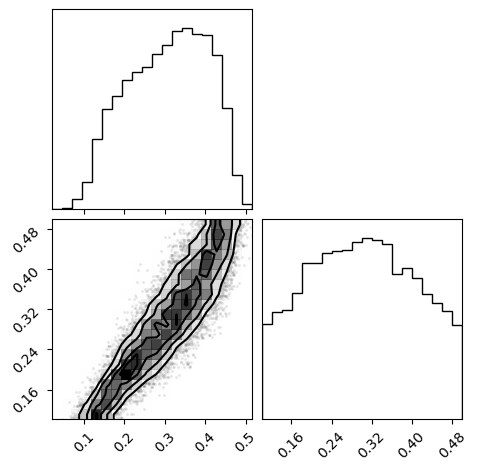

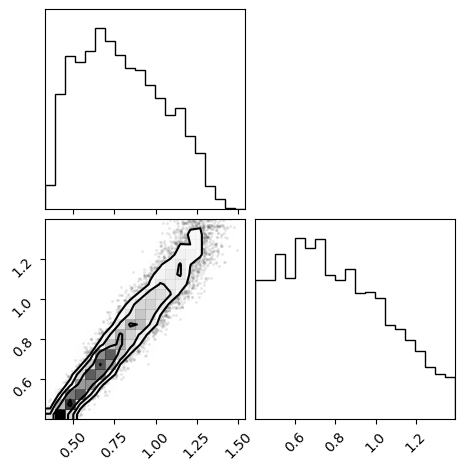

In [46]:
import corner

for ind in [0, 1]:
    corner.corner(np.vstack((predictions[:, ind], plot_y[:, ind])).T)

In [47]:
np.savez("resnet", plot_y=plot_y, predictions=predictions)

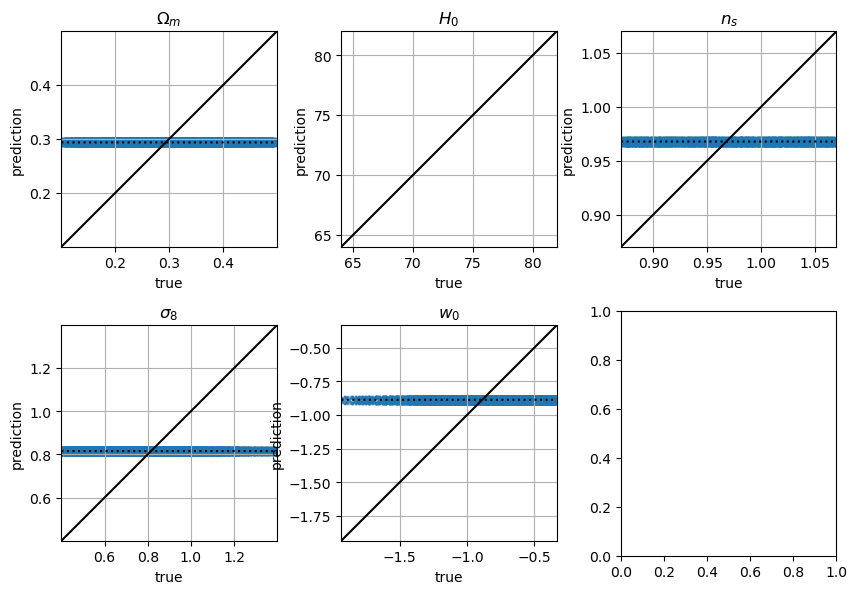

In [144]:
plot_y, predictions = preds.label_ids, preds.predictions

upp_lims = np.nanmax(plot_y, axis=0)
low_lims = np.nanmin(plot_y, axis=0)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = [r"$\Omega_m$", r"$H_0$", r"$n_s$", r"$\sigma_8$", r"$w_0$", r"$$"]
for ind, (label, ax, low_lim, upp_lim) in enumerate(zip(labels, axs.ravel(), low_lims, upp_lims)):
    p = np.poly1d(np.polyfit(plot_y[:, ind], predictions[:, ind], 1))
    ax.scatter(plot_y[:, ind], predictions[:, ind], marker="x", alpha=0.1)
    ax.set_xlabel("true")
    ax.set_ylabel("prediction")
    ax.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
    ax.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
    ax.set_xlim([low_lim, upp_lim])
    ax.set_ylim([low_lim, upp_lim])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(label)
    ax.grid()
plt.show()
plt.close()